# Session 4

In this session, we will build and train a neural network for the EGFR activity prediction task using **Pytorch**.

**Content:**
1. What is Pytorch?
2. Tensor
3. Dataset and DataLoader
4. Defining the Neural Network (MLP)
5. Training
6. Testing

In [1]:
!pip install PyTDC
import torch

print(torch.__version__)

2.8.0+cu126


In [2]:
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install rdkit

In [3]:
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(42)

## What is Pytorch?
From [Nvidia](https://www.nvidia.com/en-us/glossary/pytorch/):
> **PyTorch** is a fully featured framework for building deep learning models, which is a type of machine learning that’s commonly used in applications like image recognition and language processing. Written in Python, it’s relatively easy for most machine learning developers to learn and use. PyTorch is distinctive for its excellent support for GPUs and its use of reverse-mode auto-differentiation, which enables computation graphs to be modified on the fly. This makes it a popular choice for fast experimentation and prototyping.


`torch.Tensor` is PyTorch's base data structure ("data abstraction") to represent 1D (vector), 2D (matrix) or higher dimentional data.

In [5]:
# we can create a vector of only zeros
m_0 = torch.zeros(3)
print(m_0)

# or a 3 * 3 matrix of random numbers in interval [0, 1)
m_1 = torch.rand(3, 3, dtype=torch.float)
print(m_1)

tensor([0., 0., 0.])
tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408]])


## Dataset and DataLoader
[PyTorch](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html):
> PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

As we use our own dataset, we need to create a new **Dataset** class (a class that inherits from the `Dataset` superclass). This class needs to implement the following functions:
* `__init__`: the constructor function
* `__len__`: number of samples in dataset
* `__getitem__`: get a sample from the dataset at given index

In [6]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem

fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)


def smilesToFp(smiles):
    return fpgen.GetFingerprintAsNumPy(Chem.MolFromSmiles(smiles))

In [7]:
class ActivityDataset(Dataset):
    def __init__(self, smiles, activity):
        self.fingerprints = torch.tensor(
            list(map(smilesToFp, smiles)), dtype=torch.float
        )
        self.labels = torch.tensor(activity, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        fingerprint = self.fingerprints[idx]
        label = self.labels[idx]
        return fingerprint, label

Let's first load our EGFR dataset:

In [8]:
egfr_activities_df = pd.read_csv(
    "https://github.com/volkamerlab/cic_summerschool_2025/raw/refs/heads/main/data/EGFR-activities-prepared.csv",
    index_col=0,
)
egfr_activities_df.head()

,pIC50,standard_units,molecule_dictionary.chembl_id,canonical_smiles
0,6.339419,nM,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1
1,5.484537,nM,CHEMBL1016,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
2,5.136677,nM,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1
3,6.494850,nM,CHEMBL102726,c1ccc(CNc2ncnc3ccccc23)cc1
4,5.387216,nM,CHEMBL103552,O=C(O)c1cc(N(Cc2ccccc2O)Cc2cc(O)ccc2O)ccc1O


And create an `ActivityDataset` instance from the full dataset:

In [9]:
dataset = ActivityDataset(
    egfr_activities_df["canonical_smiles"], egfr_activities_df["pIC50"]
)

/tmp/ipython-input-1054050812.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  self.fingerprints = torch.tensor(list(map(smilesToFp, smiles)), dtype=torch.float)


We split the dataset into a training set (75%), validation set (10%), and test set (15%) using PyTorch `random_split` function: TODO @Andrea, what are good split numbers here?

In [10]:
n_train = int(0.7 * len(dataset))
n_valid = int(0.1 * len(dataset))
n_test = len(dataset) - n_train - n_valid

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42)
)

For each split, we also create a `DataLoader` instance:

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

## Defining the Neural Network (MLP)
Here, we will build a simple **feedforward neural network** (multi-layer perceptron):
- Input layer: 1024 (size of the fingerprint)
- Hidden layer: 512 neurons, with ReLU activation
- Output layer: 1 neuron (predicted pIC50 value)

To build such a neural network, we need to create a subclass of PyTorch's base class `nn.Module`. In this subclass, we need to define an `__init__` function, but we also overwrite the `forward` function that defines the forward pass.

In [12]:
class ActivityNet(nn.Module):
    def __init__(self):
        super(ActivityNet, self).__init__()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training
To train our MLP, we first create an instance of NN that we train `ActivityNet`. As loss function - on which the gradient is determined -, we will use the MSE. Further, we will use the optimizer `optim.Adam` for the parameter updates.

In [13]:
model = ActivityNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

We train the model in *mini-batches*, which are small groups of samples defined by the `batch_size` in the DataLoader. This means that in every **training step** we update the model on all `batches` seperatly.

Let's define one **training step**:

In [14]:
def train_step(loader):
    model.train()
    total_loss = 0

    # we iterate over all batches
    for fingerprints, labels in train_dataloader:

        # zero the gradients,
        # otherwise the new gradients will be added to the from the last iteration gardients
        optimizer.zero_grad()

        # forward step
        outputs = model(fingerprints)

        # empirical loss (sqeeze() to tranform a (N,1) tensor (matrix) to (N,) tensor (vector))
        loss = criterion(outputs.squeeze(), labels)

        # compute the gradients
        loss.backward()

        # updates parameters (weights & bias)
        optimizer.step()
        total_loss += loss.item() * len(labels)

    return total_loss / len(loader.dataset)

After each training step, we test the model on the validation data:

In [15]:
def test_step(loader):
    model.eval()
    valid_loss = 0.0

    # do not change the gradients
    with torch.no_grad():
        for fingerprints, labels in valid_dataloader:
            outputs = model(fingerprints)
            valid_loss += criterion(outputs.squeeze(), labels).item()
    valid_loss /= len(valid_dataloader)
    return valid_loss

We are now, ready to train the NN in *epochs*:

In [16]:
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_step(train_dataloader)
    valid_loss = test_step(valid_dataloader)

    print(
        f"Epoch: {epoch + 1:03d}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}"
    )

Epoch: 001, Train Loss: 4.1041, Validation Loss: 1.2175
Epoch: 002, Train Loss: 1.0382, Validation Loss: 1.0064
Epoch: 003, Train Loss: 0.8297, Validation Loss: 0.8872
Epoch: 004, Train Loss: 0.6918, Validation Loss: 0.8461
Epoch: 005, Train Loss: 0.5840, Validation Loss: 0.7820
Epoch: 006, Train Loss: 0.4925, Validation Loss: 0.7816
Epoch: 007, Train Loss: 0.4186, Validation Loss: 0.7099
Epoch: 008, Train Loss: 0.3538, Validation Loss: 0.7050
Epoch: 009, Train Loss: 0.3060, Validation Loss: 0.7321
Epoch: 010, Train Loss: 0.2754, Validation Loss: 0.7121
Epoch: 011, Train Loss: 0.2358, Validation Loss: 0.7049
Epoch: 012, Train Loss: 0.2134, Validation Loss: 0.7130
Epoch: 013, Train Loss: 0.1875, Validation Loss: 0.7136
Epoch: 014, Train Loss: 0.1710, Validation Loss: 0.7200
Epoch: 015, Train Loss: 0.1646, Validation Loss: 0.7362
Epoch: 016, Train Loss: 0.1563, Validation Loss: 0.7681
Epoch: 017, Train Loss: 0.1316, Validation Loss: 0.7543
Epoch: 018, Train Loss: 0.1138, Validation Loss:

## Testing

In [17]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for fingerprints, labels in test_dataloader:
        outputs = model(fingerprints)
        test_loss += criterion(outputs.squeeze(), labels).item()
test_loss /= len(test_dataloader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.8276


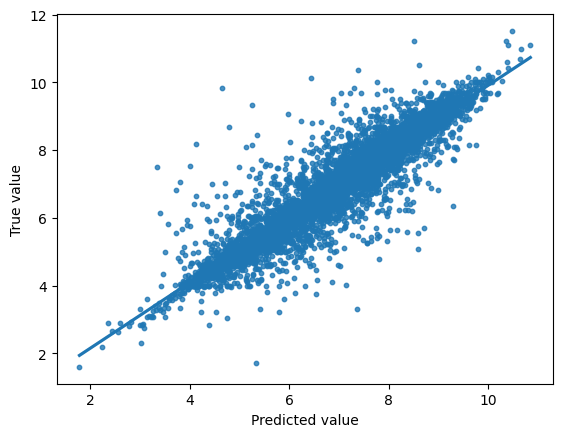

In [18]:
with torch.no_grad():
    sns.regplot(
        x=model(test_dataloader.dataset.dataset.fingerprints).squeeze().tolist(),
        y=test_dataloader.dataset.dataset.labels.tolist(),
        scatter_kws={"s": 10},
    )
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.show()

TODO place somewhere: Useful links:
* python classes: https://docs.python.org/3/tutorial/classes.html
* Dataloader & Dataset: https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html
* Step by step pythorch tut:
* Tensors tut:

## Exercises

### Exercise 1

In [19]:
# Create a MLP that has 4 layers: input layer -> hidden layer with 256 neurons and ReLU activation -> hidden layer with  512 neurons and sigmoid activation -> output layer

# TODO

In [20]:
# Train the model using the Adams optimizer and the MSE loss function

# TODO

In [21]:
# Test this model

# TODO

In [22]:
# Challenge: can you improve the runtime by changeing the number of neurons in the hidden layers?

## Challenge